### Celem poniższej analizy jest sprawdzenie istotności zależności między statystyką xG (expected goals, bramek oczekiwanych) a faktycznym kształtem tabeli ligowej najwyższej klasy rozgrywkowej w Anglii w sezonie 2022/23. Zbudowano model wielomianowej regresji logistycznej, do nauczenia którego wykorzystano dane z pięciu poprzednich sezonów Premier League (wyniki spotkań oraz wartości statystyki xG osiągnięte przez drużyny w tych spotkaniach), natomiast do przeprowadzenia predykcji posłużył zbiór zawierający spotkania rozegrane w sezonie 2022/23 przed rozpoczęciem Mistrzostw Świata w Katarze (146 spotkań). Następnie postanowiono obliczyć oczekiwane liczby punktów oraz przewidywane miejsca w tabeli według modelu oraz obliczyć współczynnik korelacji rang Spearmana między rzeczywistą i przewidywaną tabelą. Okazało się, że istnieje umiarkowanie silna dodatnia korelacja, co pozwala na wyciągnięcie wniosku, iż statystyka xG jest względnie dobrym predyktorem kształtu tabeli ligowej.

## Import niezbędnych bibliotek

In [1]:
import pandas as pd
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

## Wczytanie danych

In [2]:
#Wczytanie danych pochodzących ze strony FBref
#pl_results - wyniki z pięciu poprzednich sezonów (2017/18 - 2021/2022)
#pl_current - wyniki spotkań rozegranych przed rozpoczęciem mundialu w Katarze w sezonie 2022/23

pl_results = pd.read_csv('.../PL_res_xG.csv', encoding='cp1252')
pl_current = pd.read_csv('.../PL_2022_23.csv', encoding='cp1252')

In [3]:
#pl_results
#pl_current

In [4]:
#Zmiana nazw kolumn

pl_results.rename(columns = ({'Wk': 'GW', 'xG': 'xG_Home', 'xG.1': 'xG_Away'}), inplace = True)
pl_current.rename(columns = ({'Wk': 'GW', 'xG': 'xG_Home', 'xG.1': 'xG_Away'}), inplace = True)

#pl_results
#pl_current

In [5]:
#Zmiana formatu na datę

pl_results["Date"]= pd.to_datetime(pl_results["Date"])
pl_current["Date"]= pd.to_datetime(pl_current["Date"])

#pl_results
#pl_current

In [6]:
#Dodanie kolumn z informacją o sezonie, w którym dane spotkanie zostało rozegrane

season = []
for i in range(len(pl_results)):
    if pl_results.Date[i] < date(2018, 7, 1):
        season.append("2017/18")
    elif pl_results.Date[i] < date(2019, 7, 1):
        season.append("2018/19")
    elif pl_results.Date[i] < date(2020, 8, 1):
        season.append("2019/20")
    elif pl_results.Date[i] < date(2021, 7, 1):
        season.append("2020/21")
    else:
        season.append("2021/22")
        
pl_current["Season"] = "2022/23"

C:\Users\krzys\AppData\Local\Temp\ipykernel_5528\780382409.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if pl_results.Date[i] < date(2018, 7, 1):
C:\Users\krzys\AppData\Local\Temp\ipykernel_5528\780382409.py:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  elif pl_results.Date[i] < date(2019, 7, 1):
C:\Users\krzys\AppData\Local\Temp\ipykernel_5528\780382409.py:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date(

In [7]:
#Rozbicie zmiennej "Score" na 2 zmienne z informacją o liczbie zdobytych przez każdą z drużyn bramek

home_score = []
away_score = []

home_score1 = []
away_score1 = []

for i in range(len(pl_results)):
    home_score.append(pl_results.Score[i][0])
    away_score.append(pl_results.Score[i][2])
    
for i in range(len(pl_current)):
    home_score1.append(pl_current.Score[i][0])
    away_score1.append(pl_current.Score[i][2])

In [8]:
pl_results["Home_score"] = home_score
pl_results["Away_score"] = away_score
pl_results["Season"] = season

pl_current["Home_score"] = home_score1
pl_current["Away_score"] = away_score1

#pl_results
#pl_current

In [9]:
#Dodanie zmiennej przechowującej informacje o rezultacie danego spotkania
#(2 - zwycięstwo gospodarzy, 1 - remis, 0 - zwycięstwo gości)

winner = []
winner1 = []

for i in range(len(pl_results)):
    if pl_results.Home_score[i] > pl_results.Away_score[i]:
        winner.append(2)
    elif pl_results.Home_score[i] < pl_results.Away_score[i]:
        winner.append(0)
    else:
        winner.append(1)
        
for i in range(len(pl_current)):
    if pl_current.Home_score[i] > pl_current.Away_score[i]:
        winner1.append(2)
    elif pl_current.Home_score[i] < pl_current.Away_score[i]:
        winner1.append(0)
    else:
        winner1.append(1)

In [10]:
pl_results["Winner"] = winner

pl_current["Winner"] = winner1

#pl_results
#pl_current

In [11]:
#Wybór najistotniejszych w dalszej analizie zmiennych

pl_results_key = pl_results.loc[:, ['GW', 'Home', 'Away', 'Home_score', 'Away_score', 'xG_Home', 'xG_Away', 'Season', 'Winner']]

pl_current_key = pl_current.loc[:, ['GW', 'Home', 'Away', 'Home_score', 'Away_score', 'xG_Home', 'xG_Away', 'Season', 'Winner']]

#pl_results_key
#pl_current_key

## Przygotowanie zbiorów z wynikami z poprzednich (pl_results_key) oraz aktualnych rozgrywek (pl_current_key) do dalszej analizy

In [12]:
#Stworzenie zmiennych 0-1 z informacją o gospodarzu oraz gościu danego meczu

pl_results_key_final = pd.get_dummies(pl_results_key, prefix = ['Home', 'Away'], 
                                              columns = ['Home', 'Away'])
pl_results_key_final = pl_results_key_final.drop(['Season', 'Home_score', 'Away_score'], axis = 1)
pl_results_key_final

,GW,xG_Home,xG_Away,Winner,Home_Arsenal,Home_Aston Villa,Home_Bournemouth,Home_Brentford,Home_Brighton,Home_Burnley,...,Away_Norwich City,Away_Sheffield Utd,Away_Southampton,Away_Stoke City,Away_Swansea City,Away_Tottenham,Away_Watford,Away_West Brom,Away_West Ham,Away_Wolves
0,1,2.5,1.5,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2.1,2.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1.1,1.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.3,0.5,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1.5,0.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,38,0.5,3.4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1896,38,3.7,0.3,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1897,38,3.1,1.4,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1898,38,1.8,1.9,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Przygotowanie danych do regresji - podział zbioru na 2 podzbiory: ze zmienną objaśnianą oraz objaśniającymi

X = pl_results_key_final.drop(['Winner'], axis = 1)
y = pl_results_key_final['Winner']
y = y.astype('int')

In [14]:
#Podział na zbiory uczący i testowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [15]:
#Zastosowanie wielomianowej regresji logistycznej

mul_lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
mul_lr.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [16]:
#Sprawdzenie score'ów na zbiorach uczącym i testowym

score_train = mul_lr.score(X_train, y_train)
score_test = mul_lr.score(X_test, y_test)

In [17]:
score_train

0.6255639097744361

In [18]:
score_test

0.5982456140350877

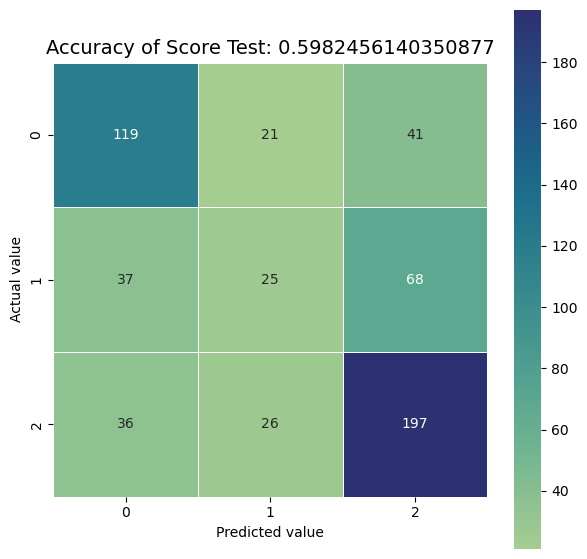

In [19]:
#Wizualizacja w postaci macierzy pomyłek

preds = mul_lr.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, preds)

plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'crest');
plt.ylabel('Actual value');
plt.xlabel('Predicted value');
all_sample_title = 'Accuracy of Score Test: {0}'.format(score_test)
plt.title(all_sample_title, size = 14);

In [20]:
#Ograniczenie zbioru do potrzebnych zmiennych

pl_current_key_final = pl_current_key.drop(['Home_score', 'Away_score', 'Season'], axis = 1)

pl_current_key_final

,GW,Home,Away,xG_Home,xG_Away,Winner
0,1,Crystal Palace,Arsenal,1.2,1.0,0
1,1,Fulham,Liverpool,1.2,1.2,1
2,1,Tottenham,Southampton,1.5,0.5,2
3,1,Newcastle Utd,Nott'ham Forest,1.7,0.3,2
4,1,Leeds United,Wolves,0.8,1.3,2
...,...,...,...,...,...,...
141,16,Nott'ham Forest,Crystal Palace,1.1,1.2,2
142,16,Newcastle Utd,Chelsea,1.0,0.3,2
143,16,Wolves,Arsenal,0.7,2.1,0
144,16,Brighton,Aston Villa,0.6,1.5,0


## Predykcja

In [21]:
#Stworzenie zmiennych 0-1 z informacją o gospodarzu/gościu danego spotkania (jak kilkanaście linijek wcześniej)

pl_prediction = pd.get_dummies(pl_current_key_final, prefix = ['Home', 'Away'], columns = ['Home', 'Away'])

missing_dummies = set(pl_results_key_final) - set(pl_prediction.columns)

for j in missing_dummies:
    pl_prediction[j] = 0
pl_prediction = pl_prediction[pl_results_key_final.columns]

pl_prediction = pl_prediction.drop('Winner', axis = 1)
pl_prediction

,GW,xG_Home,xG_Away,Home_Arsenal,Home_Aston Villa,Home_Bournemouth,Home_Brentford,Home_Brighton,Home_Burnley,Home_Cardiff City,...,Away_Norwich City,Away_Sheffield Utd,Away_Southampton,Away_Stoke City,Away_Swansea City,Away_Tottenham,Away_Watford,Away_West Brom,Away_West Ham,Away_Wolves
0,1,1.2,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1.2,1.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1.5,0.5,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1.7,0.3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.8,1.3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,16,1.1,1.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142,16,1.0,0.3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143,16,0.7,2.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144,16,0.6,1.5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Prognoza zwycięzców na podstawie wcześniej zbudowanego modelu

prediction = mul_lr.predict(pl_prediction)
prediction

array([1, 0, 2, 2, 0, 2, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 1, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 2, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 1,
       0, 2, 2, 2, 2, 0, 0, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0,
       0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0,
       2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1,
       2, 2, 1, 0, 2, 2, 0, 1, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 0,
       0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0])

In [23]:
#Dodanie do zbioru z wynikami bieżącego sezonu następujących zmiennych: przewidywanego przez model zwycięzcy
#oraz prawdopodobieństw zwycięstwa/remisu/porażki drużyny gospodarzy

predict = list(prediction)
pl_current_key['Predicted_winner'] = predict

In [24]:
lista2 = []
lista1 = []
lista0 = []

for i in range(len(pl_current_key)):
    lista2.append(round(mul_lr.predict_proba(pl_prediction)[i][2], 3))
    lista1.append(round(mul_lr.predict_proba(pl_prediction)[i][1], 3))
    lista0.append(round(mul_lr.predict_proba(pl_prediction)[i][0], 3))

In [25]:
pl_current_key['Home_win_proba'] = lista2
pl_current_key['Draw_proba'] = lista1
pl_current_key['Away_win_proba'] = lista0

pl_current_key

,GW,Home,Away,Home_score,Away_score,xG_Home,xG_Away,Season,Winner,Predicted_winner,Home_win_proba,Draw_proba,Away_win_proba
0,1,Crystal Palace,Arsenal,0,2,1.2,1.0,2022/23,0,1,0.274,0.392,0.334
1,1,Fulham,Liverpool,2,2,1.2,1.2,2022/23,1,0,0.114,0.321,0.564
2,1,Tottenham,Southampton,4,1,1.5,0.5,2022/23,2,2,0.622,0.303,0.076
3,1,Newcastle Utd,Nott'ham Forest,2,0,1.7,0.3,2022/23,2,2,0.582,0.336,0.081
4,1,Leeds United,Wolves,2,1,0.8,1.3,2022/23,2,0,0.137,0.427,0.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,16,Nott'ham Forest,Crystal Palace,1,0,1.1,1.2,2022/23,2,0,0.255,0.265,0.479
142,16,Newcastle Utd,Chelsea,1,0,1.0,0.3,2022/23,2,2,0.491,0.312,0.197
143,16,Wolves,Arsenal,0,2,0.7,2.1,2022/23,0,0,0.165,0.204,0.631
144,16,Brighton,Aston Villa,1,2,0.6,1.5,2022/23,0,0,0.142,0.244,0.613


In [26]:
#Stworzenie listy ze wszystkimi uczestnikami tegorocznych rozgrywek (2022/23)

drużyny = []

for i in range(len(pl_current_key)):
    if pl_current_key['Home'][i] not in drużyny:
        drużyny.append(pl_current_key['Home'][i])
print(drużyny)

['Crystal Palace', 'Fulham', 'Tottenham', 'Newcastle Utd', 'Leeds United', 'Bournemouth', 'Everton', 'Leicester City', 'Manchester Utd', 'West Ham', 'Aston Villa', 'Manchester City', 'Southampton', 'Wolves', 'Arsenal', 'Brighton', 'Brentford', "Nott'ham Forest", 'Chelsea', 'Liverpool']


In [27]:
#Obliczenie rzeczywistej liczby punktów zdobytych przez każdą z drużyn oraz tej przewidywanej przez model liczonej
#według wzoru 3 * suma prawdopodobieństw zwycięstw + 1 * suma prawdopodobieństw remisów

rzeczywiste_punkty = []

for i in range(len(drużyny)):
    suma = 0
    for j in (range(len(pl_current_key))):
        if pl_current_key['Home'][j] == drużyny[i] and pl_current_key['Winner'][j] == 2:
            suma = suma + 3
        elif pl_current_key['Home'][j] == drużyny[i] and pl_current_key['Winner'][j] == 1:
            suma = suma + 1
        elif pl_current_key['Away'][j] == drużyny[i] and pl_current_key['Winner'][j] == 0:
            suma = suma + 3
        elif pl_current_key['Away'][j] == drużyny[i] and pl_current_key['Winner'][j] == 1:
            suma = suma + 1
        else:
            None
    suma = round(suma, 2)
    rzeczywiste_punkty.append(suma)

In [28]:
przewidywane_punkty = []

for i in range(len(drużyny)):
    suma = 0
    for j in (range(len(pl_current_key))):
        if pl_current_key['Home'][j] == drużyny[i]:
            suma = suma + 3 * pl_current_key['Home_win_proba'][j] + pl_current_key['Draw_proba'][j]
        elif pl_current_key['Away'][j] == drużyny[i]:
            suma = suma + 3 * pl_current_key['Away_win_proba'][j] + pl_current_key['Draw_proba'][j]
        else:
            None
    suma = round(suma, 2)
    przewidywane_punkty.append(suma)

In [29]:
#Stworzenie nowej ramki danych i przypisanie drużynom rzeczywistych i prognozowanych pozycji w tabeli oraz punktów

premier_league = pd.DataFrame(drużyny, columns = ['Teams'])

In [30]:
premier_league['Actual_points'] = rzeczywiste_punkty

In [31]:
rzeczywista_pozycja = [11, 9, 4, 3, 15, 14, 17, 13, 5, 16, 12, 2, 19, 20, 1, 7, 10, 18, 8, 6]
premier_league['Actual_position'] = rzeczywista_pozycja

In [32]:
premier_league['Predicted_points'] = przewidywane_punkty

In [33]:
przewidywana_pozycja = [16, 20, 3, 5, 8, 19, 15, 13, 6, 7, 9, 1, 18, 12, 2, 14, 10, 17, 11, 4]
premier_league['Predicted_position'] = przewidywana_pozycja

In [34]:
premier_league = premier_league.sort_values(by = ['Actual_position'])

In [35]:
#Dodanie zmiennych przechowujących informacje o liczbie "ponadprogramowych" punktów oraz miejsc w tabeli (wartość dodatnia)
#oznacza, że drużyna radzi sobie lepiej niż przewidywałby model)

premier_league['Points_gain'] = premier_league['Actual_points'] - premier_league['Predicted_points']
premier_league['Position_gain'] = premier_league['Predicted_position'] - premier_league['Actual_position']
premier_league

,Teams,Actual_points,Actual_position,Predicted_points,Predicted_position,Points_gain,Position_gain
14,Arsenal,37,1,28.60,2,8.40,1
11,Manchester City,32,2,32.45,1,-0.45,-1
3,Newcastle Utd,30,3,24.29,5,5.71,2
2,Tottenham,29,4,27.15,3,1.85,-1
8,Manchester Utd,26,5,23.64,6,2.36,1
19,Liverpool,22,6,26.12,4,-4.12,-2
15,Brighton,21,7,16.83,14,4.17,7
18,Chelsea,21,8,18.48,11,2.52,3
1,Fulham,19,9,12.07,20,6.93,11
16,Brentford,19,10,19.31,10,-0.31,0


In [37]:
#Obliczenie korelacji rang Spearmana

rho, p = spearmanr(premier_league['Actual_position'], premier_league['Predicted_position'])
print(rho)
#print(p)

0.6616541353383457
